In [1]:
# import libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
#import racplusplus
import pickle
from scipy.cluster import hierarchy
import math

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#FDE74C', '#c33b43', '#697268', '#9DBF9E', '#cd5a61', '#343934', '#c91e29','#12355B','#64a0e0', '#D7816A', '#913d27', '#F46036', '#5386E4',  '#bea602', '#0a6682', '#215463']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [3]:
# import clean data set

df_wind = pd.read_csv('../../../data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [4]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


In [5]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5379910 entries, 0 to 5379909
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   asset_id              int64  
 1   read_at               object 
 2   wind_speed            float64
 3   wind_direction        float64
 4   power_average         float64
 5   rotation_average      float64
 6   exterior_temperature  float64
 7   nacelle_temperature   float64
 8   farm                  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 369.4+ MB


In [6]:
df_wind["asset_id"] = df_wind["asset_id"].astype("category")
df_wind["farm"] = df_wind["farm"].astype("category")

In [7]:
cols_int = ["wind_direction", "power_average", "exterior_temperature", "nacelle_temperature"]
df_wind[cols_int] = df_wind[cols_int].astype("int8")

cols_float = ["wind_speed", "rotation_average"]
df_wind[cols_float] = df_wind[cols_float].astype("float16")

In [8]:
df_wind["read_at"] = pd.to_datetime(df_wind["read_at"]).map(pd.Timestamp.timestamp)

In [9]:
df_wind["read_at"] = df_wind["read_at"].astype("uint32")
df_wind["read_at"]

0          1609459200
1          1609460400
2          1609474800
3          1609510800
4          1609512000
              ...    
5379905    1680169800
5379906    1680170400
5379907    1680171000
5379908    1680171600
5379909    1680172200
Name: read_at, Length: 5379910, dtype: uint32

In [10]:
df_wind[cols_float+cols_int + ["read_at"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5379910 entries, 0 to 5379909
Data columns (total 7 columns):
 #   Column                Dtype  
---  ------                -----  
 0   wind_speed            float16
 1   rotation_average      float16
 2   wind_direction        int8   
 3   power_average         int8   
 4   exterior_temperature  int8   
 5   nacelle_temperature   int8   
 6   read_at               uint32 
dtypes: float16(2), int8(4), uint32(1)
memory usage: 61.6 MB


In [11]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1


In [12]:
np.random.seed(10)

asset = df_wind['asset_id'].unique()[0]

length = len(df_wind[df_wind['asset_id'] == asset])

subset_size = int(0.01 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_wind.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

/tmp/ipykernel_680852/1485455119.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_wind.groupby('asset_id')


In [13]:
df_subset = df_subset.reset_index(drop=True)

In [14]:
n_components = 2
pca = PCA(n_components=n_components)

In [15]:
df_subset

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1640040600,8.703125,-79,-115,16.078125,7,12,1
1,11,1632084600,2.699219,-80,20,6.660156,11,27,1
2,11,1653139200,6.199219,16,-61,13.601562,22,30,1
3,11,1643802000,9.101562,114,-30,16.546875,10,13,1
4,11,1660968600,5.300781,19,-70,10.437500,22,34,1
...,...,...,...,...,...,...,...,...,...
44796,512,1627515600,3.869141,93,64,7.488281,22,26,5
44797,512,1678182000,9.281250,-23,65,13.882812,7,13,5
44798,512,1676614800,5.750000,65,-39,10.539062,6,15,5
44799,512,1638423000,10.179688,92,73,13.937500,3,10,5


In [16]:
X = df_subset.iloc[:,1:-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_pca = pca.fit_transform(X_scaled)

In [17]:
# len(df_subset[df_subset['asset_id']==11])

In [18]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
X_scaled

,0,1,2,3,4,5,6
0,-0.238071,0.749315,-1.260556,-1.744834,1.141314,-0.767843,-1.218057
1,-0.629206,-1.251346,-1.275438,0.189118,-1.373583,-0.191942,0.716077
2,0.405887,-0.085054,0.153188,-0.971253,0.479993,1.391785,1.102904
3,-0.053152,0.882084,1.611577,-0.527161,1.266485,-0.335917,-1.089115
4,0.790798,-0.384437,0.197833,-1.100183,-0.364912,1.391785,1.618673
...,...,...,...,...,...,...,...
44796,-0.853829,-0.861497,1.299066,0.819443,-1.152447,1.391785,0.587135
44797,1.637049,0.941961,-0.427191,0.833769,0.555096,-0.767843,-1.089115
44798,1.560001,-0.234745,0.882383,-0.656091,-0.337792,-0.911818,-0.831230
44799,-0.317596,1.241344,1.284184,0.948373,0.569699,-1.343744,-1.475941


# Hierarchical clustering

## Aglomerative

### Single Link

In [53]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=0.5, n_clusters=None)
model_single.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, linkage='single',
                        n_clusters=None)

In [54]:
model_single.n_clusters_

38586

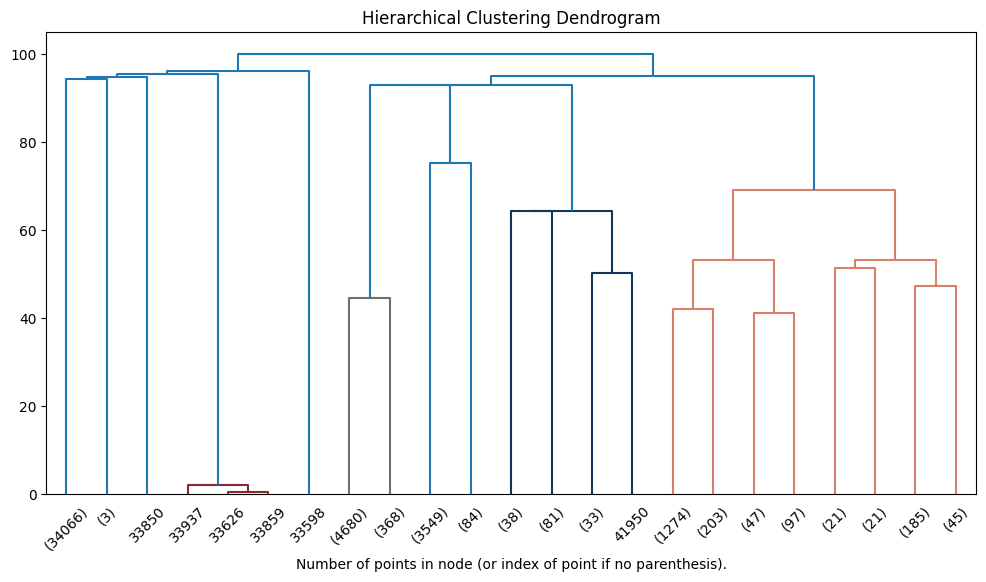

In [56]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_single, truncate_mode='level', p = 4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [58]:
# Cut dendrogram to obtain labels
num_clusters = 71  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
                                  np.ones_like(model_single.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[ 1  1  1 ... 68 68 68]


In [59]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])
df_wind = df_wind.drop(columns=['cluster_label'])

In [60]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut
X_scaled['asset_id'] = df_subset['asset_id']

In [61]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

/tmp/ipykernel_664473/2941879976.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,1
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1,1
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1,1
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1,1
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1,1


In [62]:
len(most_frequent_clusters.unique())

5

In [63]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

/tmp/ipykernel_664473/2794940810.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  representative_points = df_wind.groupby(['asset_id']).first().reset_index()


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,1
1,12,1609459800,8.500000,58,64,15.539062,-1,12,1,1
2,13,1609459200,8.101562,-49,-19,15.226562,-2,5,1,1
3,14,1609459200,8.601562,-38,-99,15.960938,-1,15,1,1
4,15,1609459200,8.796875,-47,-26,16.109375,-2,7,1,1
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.699219,-106,62,7.750000,7,15,4,56
67,415,1609459200,4.500000,29,-128,9.390625,2,11,4,56
68,510,1609459200,8.453125,50,49,13.812500,1,8,5,68
69,511,1609459200,8.320312,45,30,13.656250,3,10,5,68


/tmp/ipykernel_664473/1167155771.py:21: UserWarning: The palette list has more values (16) than needed (5), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


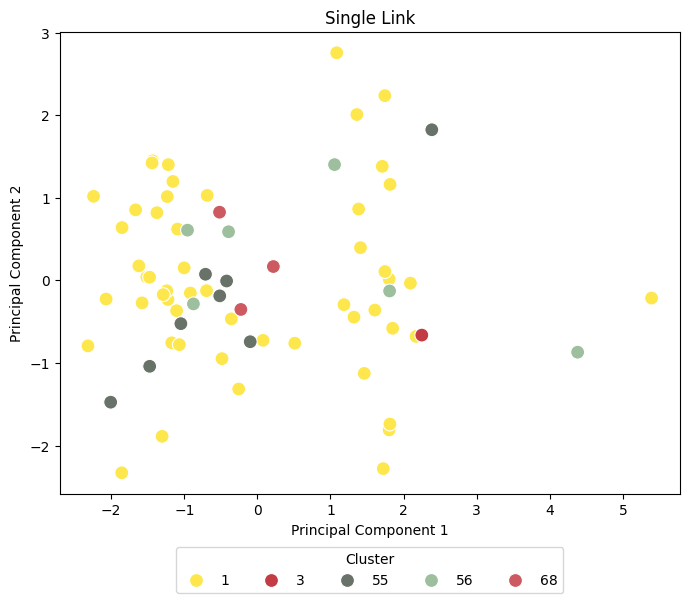

In [64]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title('Single Link')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [65]:
with open('results/hierarchical/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [66]:
df_wind.to_csv('results/hierarchical/single_link.csv')

In [67]:
df_wind = df_wind.drop(columns='cluster_label')

In [68]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

### Average Link

In [20]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=0.5, n_clusters=None)
model_average.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, linkage='average',
                        n_clusters=None)

In [23]:
# Cut dendrogram to obtain labels
num_clusters = 71  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
                                  np.ones_like(model_average.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[51 34 13 ... 18 59 15]


In [24]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut

In [25]:
X_scaled['asset_id'] = df_subset['asset_id']

In [ ]:
df_wind = df_wind.drop(columns=['cluster_label_x', 'cluster_label_y', 'cluster_label'])

In [29]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()



/tmp/ipykernel_680852/4273624517.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,34
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1,34
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1,34
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1,34
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1,34


In [30]:
len(most_frequent_clusters.unique())

12

In [31]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

/tmp/ipykernel_680852/2794940810.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  representative_points = df_wind.groupby(['asset_id']).first().reset_index()


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,34
1,12,1609459800,8.500000,58,64,15.539062,-1,12,1,34
2,13,1609459200,8.101562,-49,-19,15.226562,-2,5,1,20
3,14,1609459200,8.601562,-38,-99,15.960938,-1,15,1,34
4,15,1609459200,8.796875,-47,-26,16.109375,-2,7,1,34
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.699219,-106,62,7.750000,7,15,4,15
67,415,1609459200,4.500000,29,-128,9.390625,2,11,4,34
68,510,1609459200,8.453125,50,49,13.812500,1,8,5,32
69,511,1609459200,8.320312,45,30,13.656250,3,10,5,15


/tmp/ipykernel_680852/4154262498.py:21: UserWarning: The palette list has more values (16) than needed (12), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


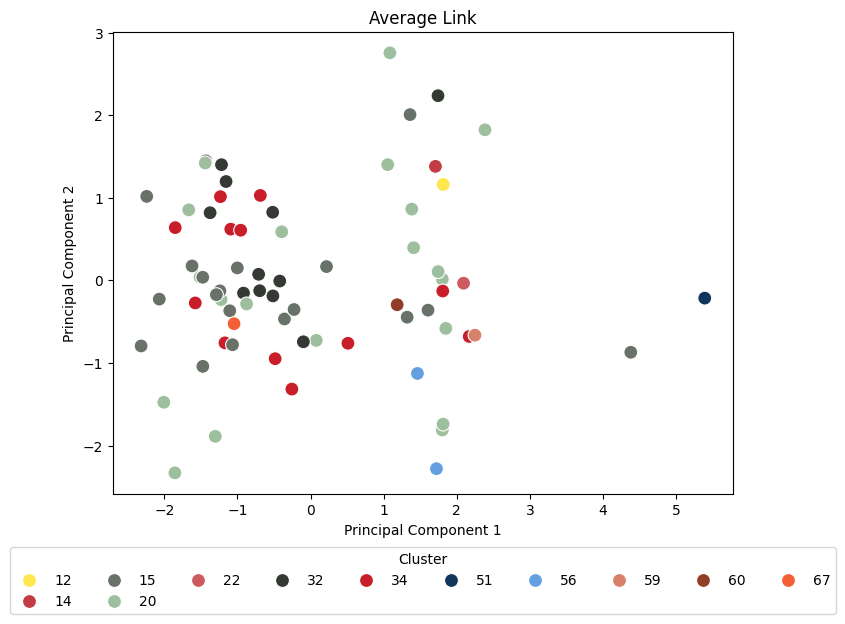

In [32]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title('Average Link')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [33]:
with open('results/hierarchical/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [35]:
df_wind.to_csv('results/hierarchical/average_link.csv')

In [54]:
df_wind = df_wind.drop(columns='cluster_label')

In [55]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

### Ward's method

In [38]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.5, n_clusters=None)
model_ward.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)

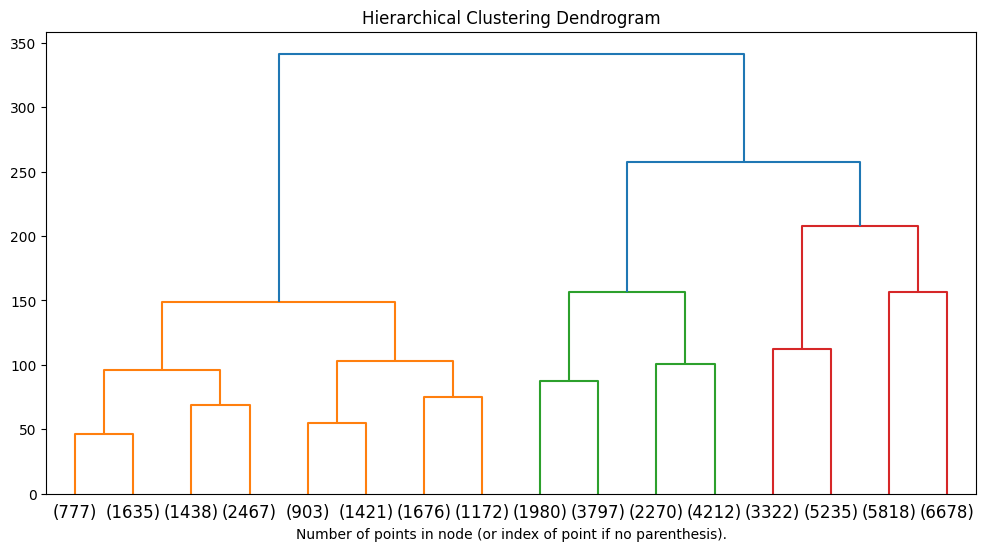

In [39]:
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [40]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1


In [41]:
X_scaled

,0,1,2,3,4,5,6
0,-0.238071,0.749315,-1.260556,-1.744834,1.141314,-0.767843,-1.218057
1,-0.629206,-1.251346,-1.275438,0.189118,-1.373583,-0.191942,0.716077
2,0.405887,-0.085054,0.153188,-0.971253,0.479993,1.391785,1.102904
3,-0.053152,0.882084,1.611577,-0.527161,1.266485,-0.335917,-1.089115
4,0.790798,-0.384437,0.197833,-1.100183,-0.364912,1.391785,1.618673
...,...,...,...,...,...,...,...
44796,-0.853829,-0.861497,1.299066,0.819443,-1.152447,1.391785,0.587135
44797,1.637049,0.941961,-0.427191,0.833769,0.555096,-0.767843,-1.089115
44798,1.560001,-0.234745,0.882383,-0.656091,-0.337792,-0.911818,-0.831230
44799,-0.317596,1.241344,1.284184,0.948373,0.569699,-1.343744,-1.475941


In [127]:
X_scaled = X_scaled.drop(columns='cluster_label')

In [56]:
# Cut dendrogram to obtain labels
num_clusters = 71/3  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
                                  np.ones_like(model_ward.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[19 15 12 ... 20  5 19]


In [57]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut

In [58]:
X_scaled['asset_id'] = df_subset['asset_id']

In [59]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

/tmp/ipykernel_680852/2941879976.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,15
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1,15
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1,15
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1,15
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1,15


In [60]:
len(most_frequent_clusters.unique())

12

In [61]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

/tmp/ipykernel_680852/2794940810.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  representative_points = df_wind.groupby(['asset_id']).first().reset_index()


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1,15
1,12,1609459800,8.500000,58,64,15.539062,-1,12,1,18
2,13,1609459200,8.101562,-49,-19,15.226562,-2,5,1,21
3,14,1609459200,8.601562,-38,-99,15.960938,-1,15,1,20
4,15,1609459200,8.796875,-47,-26,16.109375,-2,7,1,18
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.699219,-106,62,7.750000,7,15,4,18
67,415,1609459200,4.500000,29,-128,9.390625,2,11,4,18
68,510,1609459200,8.453125,50,49,13.812500,1,8,5,20
69,511,1609459200,8.320312,45,30,13.656250,3,10,5,20


/tmp/ipykernel_680852/2185764408.py:21: UserWarning: The palette list has more values (16) than needed (12), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


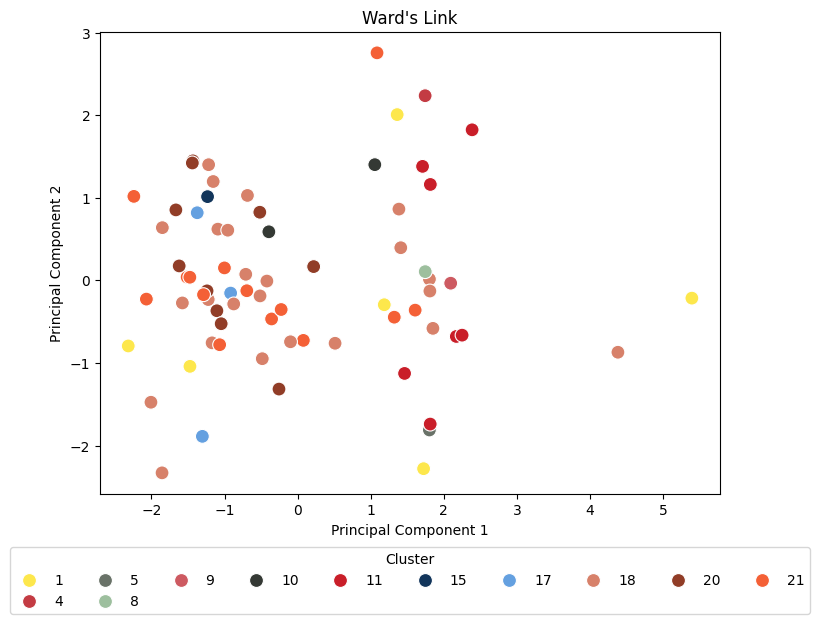

In [62]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title("Ward's Link")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [63]:
with open('results/hierarchical/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward, f)

In [64]:
df_wind.to_csv('results/hierarchical/ward_link.csv')

In [65]:
df_wind = df_wind.drop(columns='cluster_label')